In [3]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
from IPython import display
import datetime
import time
from utils import *

from _multi_scale_attn_gan import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
print(tf.config.list_physical_devices('GPU'))
print(tf.test.is_built_with_cuda())

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
True


In [5]:
dates = ['winter', 'spring', 'summer']
zoom = 16
shadow_path = 'data/shadows/'
height_path = 'data/heights_new/'

BATCH_SIZE = 1
TILES_PER_CITY = 790 # 95% of 790 is 750. The rest 40 are used for validation
STEPS = 40000

In [6]:
lat, dat = True, True

In [7]:
# Case: Uniform Distribution of Latitudes

train_cities = ['aus', 'par', 'syd', 'sp', 'mex', 'la', 'chi']
test_cities = ['dc', 'nyc', 'joh', 'bue', 'bos', 'sea', 'tok']

In [8]:
checkpoint_name = 'uniform_cities_multi_gan_attn' + '__ssim_with_sobel'
checkpoint_path = 'training_checkpoints_new/%s' % (checkpoint_name)

Time taken for 1000 steps: 1632.77 sec



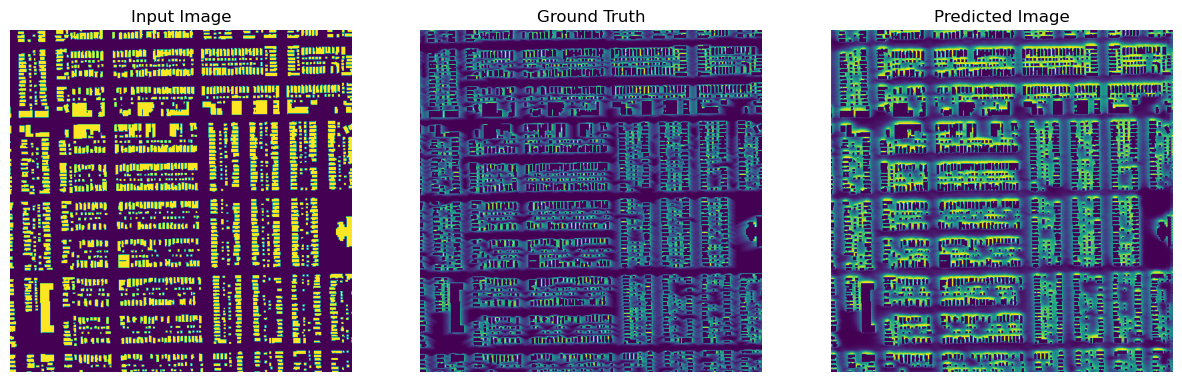

Step: 39k
gan_loss 1.01453
disc_loss 0.819853246
gen_total_loss 4621.46338
....................................................................................................

In [16]:
tf.keras.backend.clear_session()

train_dataset, validation_dataset = get_train_test(
    height_path, shadow_path, train_cities, dates, zoom, TILES_PER_CITY, BATCH_SIZE, train_size =  0.95)

multi_gan = MultiGAN(512, 512, latitude=lat, date=dat, loss_funcs=[ssim_loss, sobel_loss], type='resnet9', attention=True, model_name=checkpoint_name)
multi_gan.fit(checkpoint_path, train_dataset, validation_dataset, STEPS)

In [10]:
tf.keras.backend.clear_session()
multi_gan = MultiGAN(512, 512, latitude=lat, date=dat, loss_funcs=[ssim_loss, sobel_loss], type='resnet9', attention=True, model_name=checkpoint_name)
multi_gan.restore(checkpoint_path)

In [8]:
# Store results for multi-gan

for city in test_cities:
    test = [city]

    test_dataset = get_tiles(height_path, shadow_path, test, dates, zoom, 750)
    test_dataset = test_to_tensor(test_dataset, BATCH_SIZE)

    df = pd.read_csv('data/compare_models_new/results_new.csv')
    rmses, maes, mses, ssims, sobels = get_metrics_multi(512, 512, test_dataset, multi_gan.generators, latitude=lat, date=dat)
    df.loc[len(df.index)] = [checkpoint_name, city, np.average(maes), np.average(mses), np.average(rmses), np.average(ssims), np.average(sobels)] 
    df.to_csv('data/compare_models_new/results_new.csv', index=False)

    print('\nCity %s rmse: %.2f mae: %.2f mses: %.2f' %
      (city, np.average(rmses), np.average(maes), np.average(mses)))


City dc rmse: 0.09 mae: 0.03 mses: 0.01

City nyc rmse: 0.10 mae: 0.04 mses: 0.01

City joh rmse: 0.03 mae: 0.01 mses: 0.00

City bue rmse: 0.05 mae: 0.02 mses: 0.00

City bos rmse: 0.09 mae: 0.04 mses: 0.01

City sea rmse: 0.08 mae: 0.04 mses: 0.01

City tok rmse: 0.10 mae: 0.05 mses: 0.01


In [12]:
# Store images for multi-gan

for city in test_cities:
    test = [city]
    test_dataset = get_tiles(height_path, shadow_path, test, dates, zoom, 750)
    test_dataset = test_to_tensor(test_dataset, BATCH_SIZE)

    if not os.path.exists('data/compare_models_new/%s/%s' % (checkpoint_name, city)):
        os.makedirs('data/compare_models_new/%s/%s' % (checkpoint_name, city))

    df = pd.read_csv('data/tile_heights/%s-16.csv' %(city))
    df = df.sort_values(by=['height'], ascending=False)

    top = df.head(6)
    middle = df.iloc[len(df)//2-3:len(df)//2+3]
    bottom = df.tail(6)
    # concat
    all = pd.concat([top, middle, bottom])

    idx = 0
    for row in all.iterrows():
        i = int(row[1]['i'])
        j = int(row[1]['j'])

        if(idx < 2 or (idx > 5 and idx < 8) or (idx > 11 and idx < 14)): date = 'summer'
        elif((idx > 1 and idx < 4) or (idx > 7 and idx < 10) or (idx > 13 and idx < 16)): date = 'winter'
        else: date = 'spring'

        zoom = 16
        img_no = '%d_%d' % (i, j)

        plot_path = 'data/compare_models_new/%s/%s/%s_%s' % (checkpoint_name,city, img_no, date)
        test_on_image_multigan(multi_gan.generators, height_path, shadow_path, city, date, zoom, i, j, path=plot_path, save=True)

        idx += 1